# 2a. Riemann Solvers (Bodenheimer et al, chapter 6.3.3)

At the end of exercise  __1d__ last week we learned how to advect material. Advection is a central property of all Eularian numerical schemes. E.g. methods where quantities are described by a fixed grid, but material is being transported, and evolves, in the background grid. In this exercise we will generalise this setup from advection to hydrodynamics.

In [2]:
import jax
import jax.numpy as jnp
import jax.lax as lax
from jax import Array, jit
from jax.typing import ArrayLike

import numpy as onp
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport riemann

### Hydrodynamics
The equations of hydrodynamics are
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \,\mathsf{I}] & = 0 \\
\partial_t E + \mathbf{\nabla} \cdot [(E + P)\, \mathbf{v}] & = 0\,,
\end{align}
where $\rho$ is density, $\mathbf{v}$ is velocity, $P$ is pressure, and $E$ is the total energy density. $E = \rho e + {1 \over 2} \rho v^2$, and $e$ is the internal energy per mass. This is complemented by an equation of state $P = (\gamma - 1)\rho e$. $\mathsf{I}$ is the identity matrix, so that $\mathbf{\nabla} \cdot [P\,\mathsf{I}] = \mathbf{\nabla}P$.

This can also be written in the Lagranian form
\begin{align}
\partial_t \rho & = - \mathbf{v} \cdot \mathbf{\nabla} \rho
- \rho \mathbf{\nabla} \cdot \mathbf{v} \\
\partial_t \mathbf{v} & = - (\mathbf{v} \cdot \mathbf{\nabla}) \mathbf{v}
- \frac{1}{\rho} \mathbf{\nabla} P  \\
\partial_t P &= - \mathbf{v} \cdot \mathbf{\nabla} P
- \gamma P \mathbf{\nabla} \cdot \mathbf{v}\,,
\end{align}
where the advective derivative ($-\mathbf{v} \cdot \mathbf{\nabla}$) is explicit.

In the special case where the temperature is constant the equations simplify to
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \,\mathsf{I}] & = 0
\end{align}
and $P = c_s^2 \rho$, where $c_s^2 = k_b T / \mu m_p$ is the isothermal sound speed. To keep it simlpe, we will start by considering isothermal hydrodynamics. You will the yourselves add the energy equation.

### MUSCL Method for time updates
To simplfy the equations we will write the system in vector notation with a _state vector_ $U$, and a _flux vector_ $F$, and assume we have one dimension. Then
\begin{align}
U &= (\rho, \rho u) \\
F &= (\rho u, \rho u u + P) \\
\partial_t U + \partial_x F &= 0
\end{align}

From last week's lecture slide we have the __master equation__ for solving the system:
\begin{equation}
U(t + \Delta t,x_{i-1/2}) - U(t,x_{i-1/2}) = \frac{\Delta t}{\Delta x} \left[ \tilde F(t + {\Delta t \over 2},x_{i-1}) - \tilde F(t + {\Delta t \over 2},x_{i}) \right]\,,
\end{equation}
where the flux terms are integrals over the time step and the cell faces (that in 1D is just a point, but in 2D a line, and in 3D an area)
\begin{equation}
\tilde F(t + {\Delta t \over 2},x_{i}) = {1 \over \Delta t}
\int^{t + \Delta t}_t \textrm{d} t' F(t', U_I(t',x_i))\,,
\end{equation}
and $U_I$ are the point values of $U$ at the interface.

The MUSCL method improves on Godunov method by approximating the time integral and assuming that we can make a slope interpolation for the values at the interface.
The alogrithm goes as follows
  1. From the state vector $U$ compute the _primitive_ variables q = ($\rho$,$v$,$P$)
  2. Compute the spatial slopes from the center of the cell to the interface. Making the slopes monotonized (TVD) if needed. The slope accross a cell are $\Delta q_x$.
  3. Compute a naive time evolution for the primitve variables at the center of the cell using an Euler step and the Lagranian hydro equations. E.g.
\begin{equation}
\Delta q_t = \Delta t \frac{\textrm{d}q}{\textrm{d}t}
\end{equation}
  4. Approximate $q(t+\Delta t/2, x\pm\Delta x/2) = q(t,x) + (\Delta q_t \pm \Delta q_x) / 2$
  5. Shift point of view from cells to interfaces and consider fluid variables on the _left_ and _right_ sides of _interfaces_.
  6. Assume that the fluid variables are constant on each side of the cell interface, and use an (approximate) Riemann solver to compute the fluxes.

Here is the code corresponding to the algorithm. Notice how we use a _class_ to contain the experiment data and related functions, and help in readability. This makes it easy to extend the code with different variables and functions, if needed.

### Coordinates
defining a coordinate vector may seem trivial, but it is important always to have a clear picture of _where_ different cell center and interface values are placed in memory, just like when you solve exercise __1d__ with the Van Leer method. We have decided to use a so-called up-staggered coordinate system, because the interface to the right (or _up_) is placed in memory at the same position as the cell center values. We could as well have used a down-staggered coordinate system. It is a choice of convention.

### Derivatives and slope limiters

### Hydro data and auxiliary conversion methods from conservative to primitive variables
We will use a class to encapsulate all the functions we need to manipulate basic variables. Remember from exercise __1a__ how a class can contain both variables and functions, and that the first argument to a function always is the class itself. There is also a special class function "\_\_init\_\_" that populates the initial data for the class

### Riemann Solvers
First set up a two trivial functions for converting between the primitive variables $q = (\rho, v, P)$ and conservative variables $U=(\rho,\rho v, E)$, where $E$ is the total energy, and for computing the corresponding hydrodynamical flux vector. Then use those to make two example approximate Rieman solvers _LLF_ and _HLL_ that compute the flux at an interface given a left and right state.

### MUSCL time update algorithm

### Initial condition
Setup an initial condition for a sound wave traveling to the right

In [3]:
# returns a simple Sine wave traveling at velocity v evaluated at time t
def wave(x,v,t):
    f=jnp.sin(x-v*t)
    return f

def initial_condition(u,eps=0.01,rho0=1.):
        velocity = eps*u.cs*wave(u.x,0.,0.)     # velocity
        u.rho = rho0*(1. + eps*wave(u.x,0.,0.)) # density for a sound wave with relative amplitude "eps"
        u.Px = rho0*velocity                    # momentum density
        # check if not an isothermal setup, and then compute the total energy
        if u.gamma != 1.:
            P = u.cs**2 * u.rho / u.gamma
            Eint = P / (u.gamma - 1.)
            u.Etot = Eint + 0.5 * u.px**2 / u.rho


### Time Evolution Loop

In [5]:
# setup graphics
def wide_fig(C, title='',s=''):
    if title=='':
        title='{}  Courant={:.2f}'.format(s,C)
    plt.figure(figsize=(14,4))
    plt.title(title);

Number of iterations : 1320
Time                 : nan
Resolution           : 1024
Periods advected     : 1.0
CPU times: user 7.24 s, sys: 3.43 s, total: 10.7 s
Wall time: 6 s


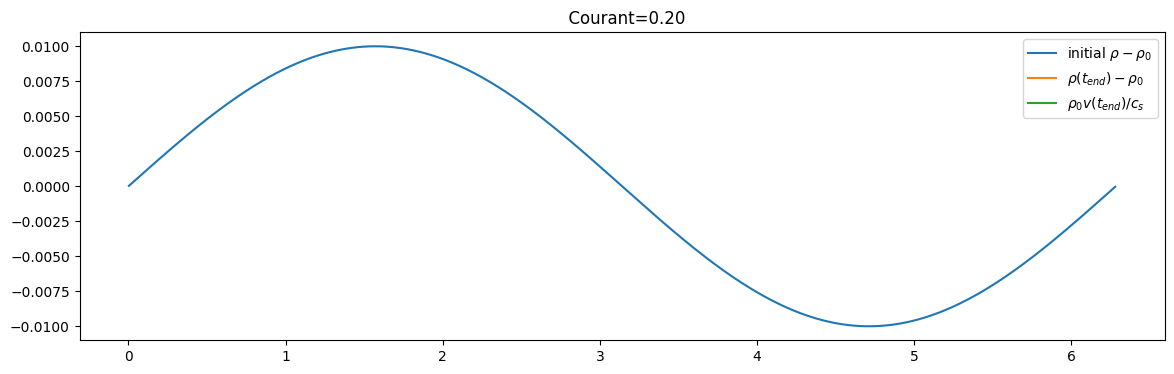

In [7]:
def run():
    n = 1024       # number of grid points
    C = 0.2        # Courant number (<0.5 for stability)
    rho0 = 1.      # Average density
    gamma = 1.     # Adiabatic index
    cs  = 1.       # Sound speed
    eps = 0.01     # relative amplitude of soundwave
    Slope = riemann.MonCen   # choose a slope
    Riemann_Solver=riemann.LLF # choose a Riemann solver
    
    # set up exepriment with a soundwave initial condition
    u = riemann.HydroState(n,gamma=1.,cs=cs)
    initial_condition(u,eps=eps,rho0=rho0)
    
    periods = 1.0  # number of periods to advect
    tend = periods*u.Lbox / u.cs # corresponding end time if wave moves with sound speed (cs)
    
    # caluclate an approximate guess for the
    # number of iterations needed
    # dt ~ C * dx / cs, since cs is the soundspeed
    # 1.5 is a safety factor, given that the phase
    # velocity of the wave may limit the time step a bit
    nt = int(1.5 * tend / (C * u.dx / cs))
    
    wide_fig(C)
    plt.plot(u.x,u.rho - rho0,'-',label=r'initial $\rho-\rho_0$')
    
    it = 0
    while(u.t < tend and it < nt):
        dt=u.Courant(C) # get size of dt
        if (u.t+dt > tend): # make sure we arrive at tend exactly
            dt = tend - u.t
    
        u = riemann.muscl(u,dt,Slope=Slope,Riemann_Solver=Riemann_Solver) # Evolve solution by dt
        # increment time and iteration count
        u.t += dt 
        it += 1
    
    # Plot the final density in orange
    plt.plot(u.x,u.rho-rho0,'-',label=r'$\rho(t_{end}) - \rho_0$')
    
    # Plot the corresponding velocity. Rescale with a factor of rho0 / u["cs"] to make
    # it same amplitude as density (can be seen by e.g. dimensional analysis)
    plt.plot(u.x,rho0*u.velocity()/u.cs,'-',label=r'$\rho_0 v(t_{end}) / c_s$')
    
    plt.legend();
    
    print("Number of iterations :", it)
    print("Time                 :", u.t)
    print("Resolution           :", u.n)
    print("Periods advected     :", periods)
    if (u.t < tend):
        print("OBS hit maximum number of iterations, something may be broken.")
        print("nt   =", nt)
        print("t    =", u.t)
        print("tend =", tend)

%time run()

In the plot above we have three quantities:
  * Blue: the initial density perturbation (the average density $\rho_0$ has been subtracted)
  * Orange: the final density perturbation
  * The velocity perturbation rescaled to units of density by dividing with sound speed and multiplying the average density (why is this a good rescaling :-? )

### Tasks:

In this exercise the learning objective is to understand the different steps in the MUSCL algorithm. We will use a simple sound wave as our setup, but the solver is general. Any other initial condition would work, such as a shock, as long as it is periodic. You are welcome to construct your own initial condition, and see what happens!

To aid in understanding how it works you will
  - extend the solver to include the total energy
  - _experimentally_ test how well the sound speed is conserved (how will you do that?)
  - relate to the physical problem of a hydrodynamical wave, by changing the parameters

The tasks are:
  1. Execute the notebook. Make a routine to measure the sound speed.
  2. Extend the algorithm to include the energy equation. What is the sound speed now; discuss why?
  3. Change the amplitude to something larger. What happens; discuss why?

### __Absalon turn-in__

Upload this notebook with answers to the tasks at the end together with a pdf of the notebook. You should make a copy of the solvers and other relevant cells below with the energy equation included. Just like as has already been done in many parts of the code, if you add if blocks like `if gamma != 1: ...` then the solver will still work in the isothermal case. 